In [6]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet
from pyramid.arima import auto_arima

from sklearn.metrics import mean_absolute_error


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [7]:
my_df = pd.read_csv('my_df.csv', index_col= 'Series')

In [8]:
exog_1 = np.array(my_df.iloc[0,6:50], dtype = np.float16).reshape(-1,1)
exog_2 = np.array(my_df.iloc[1,6:50], dtype = np.float16).reshape(-1,1)
exog_3 = np.array(my_df.iloc[2,6:50], dtype = np.float16).reshape(-1,1)
exog_4 = np.array(my_df.iloc[3,6:50], dtype = np.float16).reshape(-1,1)
exog_5 = np.array(my_df.iloc[4,6:50], dtype = np.float16).reshape(-1,1)
exog_6 = np.array(my_df.iloc[5,6:50], dtype = np.float16).reshape(-1,1)

# Plotting functions

In [9]:
def plotting_features(exog, mode):
    """
    plotting features
    """
    
    if mode == 'prophet':
        Exog = exog.values
        
    elif mode == 'pyramid':
        Exog = exog

    else:
        print("check mode")
        return None
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    #left  = 0.125  # the left side of the subplots of the figure
    #right = 0.9    # the right side of the subplots of the figure
    #bottom = 0.1   # the bottom of the subplots of the figure
    #top = 0.9      # the top of the subplots of the figure
    #wspace = 0.2   # the amount of width reserved for blank space between subplots
    #hspace = 0.2   # the amount of height reserved for white space between subplots
    
    fig.subplots_adjust(top=2, bottom=1,  right=2, left=0, wspace=0.6)
    

    ax1.plot(Time,Exog[:,0])
    ax1.set_ylabel('exog_1', bbox=box)


    ax3.set_ylabel('exog_2',bbox=box)
    ax3.plot(Time,Exog[:,1])

    labelx = -0.3  # axes coords

    ax2.plot(Time,Exog[:,2])
    ax2.set_ylabel('exog_3', bbox=box)
    ax2.yaxis.set_label_coords(labelx, 0.5)


    ax4.plot(Time,Exog[:,3])
    ax4.set_ylabel('exog_4', bbox=box)
    ax4.yaxis.set_label_coords(labelx, 0.5)

    plt.show()
    
    pass

In [10]:
def plotting_time_series(y_without_lags, y_with_lags, mode):
    """
    Plot two time series
    """
    if mode == 'prophet':
        ts_without_lags = data_without_lags["y"].values
        ts_with_lags = data_with_lags["y"].values
        
    elif mode == 'pyramid':
        ts_without_lags = y_without_lags
        ts_with_lags = y_with_lags
        
    else:
        print("Check mode")
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (3, 7))
    fig.subplots_adjust(top = 2, bottom = 1,  right = 2, left = 0, hspace = 0.2)

    ax1.plot(Time, ts_without_lags)
    ax1.set_ylabel("value", bbox = box)
    ax1.set_title("y without lags", bbox = box)


    ax2.set_ylabel("value", bbox = box)
    ax2.plot(Time, ts_with_lags)
    ax2.set_title("y with lags", bbox = box)

    #fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    plt.show()
    
    pass

In [11]:
def plot_results(time_series, Time, train_prediction, test_prediction, y_test, mode, description):
    
    """
    Plots the original time series and it prediction
    """
    if mode == 'prophet':
        ts = time_series["y"].values
        train_pr = train_prediction["yhat"].values
        test_pr = test_prediction["yhat"].values
    
    elif mode == 'pyramid':
        train_pr = train_prediction
        test_pr = test_prediction
        ts = time_series
        
    
    else:
        print("Check mode")
        return None
    
    plt.figure(figsize=(10,7))

    plt.plot(Time, ts, label = "true")
    
    plt.plot(Time[start_point+1: end_point], np.concatenate([train_pr, test_pr])[1:], 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(
             np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
             np.round(mean_absolute_error(test_pr, y_test), 3)))


    plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

    plt.xlabel("time", size = 20)
    plt.ylabel("value", size = 20)
    plt.title("{}".format(description), size = 20)


    plt.legend(fontsize = 15)

    plt.show()
    pass

# Extra functions

In [34]:
def generate_problem_M3(n_elements, mode = 'prophet', seed = 123, noise_scale = None):
    """
    Generates time-series, Exog, Time
    """
    # random seed
    np.random.seed(seed)
    
    Time = np.arange(0, n_elements)
    
    # generate exog features
    Exog = np.concatenate([exog_1, exog_2, exog_3, exog_4], axis = 1)
    
    # generate time-series
    y_without_lags = generate_ts_1(Exog, noise_scale = noise_scale)
    
    y_with_lags = generate_ts_2(Exog, noise_scale = noise_scale)
    
    if mode == 'prophet':
        
        # generate data frame
        data_without_lags = pd.DataFrame(y_without_lags)
        data_without_lags.columns = ["y"]
        data_without_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_without_lags), freq='M')

        data_with_lags = pd.DataFrame(y_with_lags)
        data_with_lags.columns = ["y"]
        data_with_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_with_lags), freq='M')

        exog = pd.DataFrame(Exog, dtype=np.float64)
        exog.columns = ["f1", "f2", "f3", "f4"]
        exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')
    
        return (data_without_lags, data_with_lags, exog, Time)
    
    elif mode == 'pyramid':
        return (y_without_lags, y_with_lags, Exog, Time)
    
    else:
        print("Check mode!")
        return None

In [35]:
def train_test_split(data, start_point, middle_point, end_point, mode, exog_flag = False):
    """
    Make train-test-split using input parameters
    """
    
    if mode == 'prophet':
        data_train = data.iloc[start_point: middle_point].copy()
        data_test = data.iloc[middle_point: end_point].copy()
        
        
        if exog_flag == False:
            
            y_test = data_test["y"].values
            del data_test["y"]
            
            return data_train, data_test, y_test
        
        else:
            
            return data_train, data_test
    
    elif mode == 'pyramid':
        
        data_train = data[start_point: middle_point]
        data_test = data[middle_point: end_point]
        
        if exog_flag == False:
            return data_train, data_test, data_test
        else:
            return data_train, data_test
        
    else:
        print("Check mode")
        return None, None, None

In [36]:
def Fit(mode, data_train, exog_train = None, params = None):
    
    """
    Fit the models
    """
    
    if mode == 'prophet':
        model = fit_prophet(data_train = data_train, exog_train = exog_train, params = params)
        
    elif mode == 'pyramid':
        model = fit_pyramid(data_train = data_train, exog_train = exog_train, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [37]:
def Predict(mode, model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Model prediction on train and test
    """
    
    if mode == 'prophet':
        model = predict_prophet(model = model, data_train = data_train, data_test = data_test, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    elif mode == 'pyramid':
        model = predict_pyramid(model = model, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [38]:
def fit_prophet(data_train, exog_train = None, params = None):
    
    """
    Method fit for prophet
    """
    
    data_train_new = data_train.copy()
    
    model = Prophet()
    
    if exog_train is not None:
        
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        
        model.add_regressor("f1")
        model.add_regressor("f2")
        model.add_regressor("f3")
        model.add_regressor("f4")

    model.fit(data_train_new)
    
    return model

In [39]:
def predict_prophet(model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Prediction for prophet
    """
    
    data_test_new = data_test.copy()
    data_train_new = data_train.copy()
    
    if exog_train is not None:
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        data_test_new = pd.merge(data_test_new, exog_test, on = "ds")
    
    forecast_train = model.predict(data_train_new)
    forecast_test = model.predict(data_test_new)
    
    return forecast_train, forecast_test

In [40]:
def fit_pyramid(data_train, exog_train = None, params = None):

    """
    pyramid_mode {"stepwise", "random_search"}

    """
    
    if params['pyramid_mode'] == "stepwise":
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5,
        m=params['period'], n_jobs = params['n_jobs'], scoring = params['scoring'], 
        out_of_sample_size = params['out_of_sample_size'], 
        start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, stepwise=True)
    
    elif params['pyramid_mode'] == 'random_search':
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5, 
        m=params['period'], scoring = params['scoring'], out_of_sample_size = params['out_of_sample_size'],
        start_P=0, start_Q = 0, n_jobs=params['n_jobs'], max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, 
        stepwise=False, random=True, random_state=params['random_state'], n_fits = params['n_fits'])
    
    return model

In [41]:
def predict_pyramid(model, exog_train = None, exog_test = None, params = None):
    
    predict_in_sample = model.predict_in_sample(exogenous = exog_train, dynamic = params['dynamic'])
    predict_out_of_sample = model.predict(n_periods = params['n_periods'], exogenous = exog_test)
    
    return predict_in_sample, predict_out_of_sample

# Data generation functions

In [42]:
def generate_ts_1(exog, noise_scale = None):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    y = y.squeeze()
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
    
    return y

def generate_ts_2(exog, noise_scale = None):
    
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
    
    return y


def generate_ts_nonlinear(exog, noise_scale = None):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    y = 0.4 * exog[:, 1] * exog[:, 2] + exog[:, 2] / exog[:, 3]
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
    
    return y

def generate_ts_nonlinear_with_lags(exog, noise_scale = None):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    y = 0.4 * exog[:, 0] * exog[:, 2] + exog[:, 1] / exog[:, 2]
    
    for i in range(2, exog.shape[0]):
        
        y[i] = y[i] + 0.2 * y[i-1] + 0.2 * y[i-2] + 0.1 * y[i-1]
    
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
        
    return y


# Testing on the last dataset - linear case

# Prophet

In [43]:
# Global_mode
global_mode = 'prophet'
noise_scale = None

# Generate problem

In [44]:
n_samples = 44
data_without_lags, data_with_lags, exog, Time = generate_problem_M3(n_samples, 
                        mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

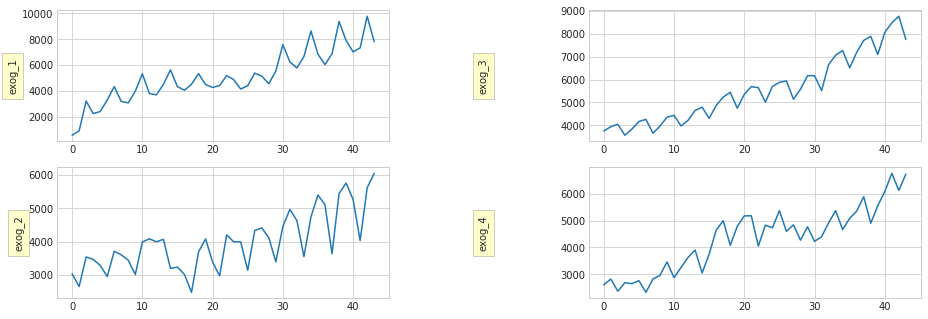

In [45]:
plotting_features(exog, global_mode)

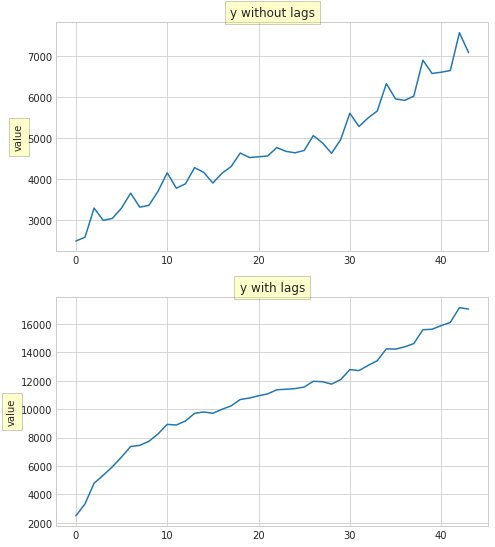

In [46]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [47]:
start_point = 0
middle_point = 35
end_point = 44

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Prophet without lags without noise without exog

In [48]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [49]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

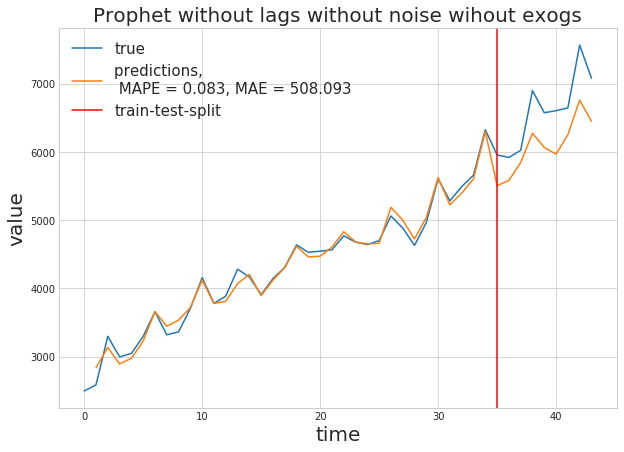

In [50]:
description = "Prophet without lags without noise wihout exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet without lags without noise with exogs 

In [51]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [52]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

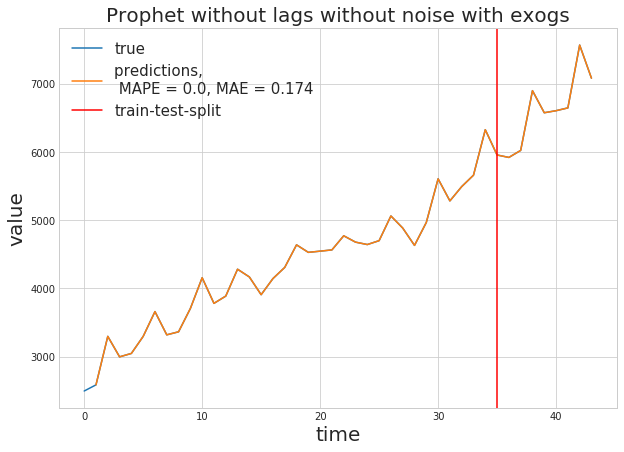

In [53]:
description = "Prophet without lags without noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet with lags without noise without exogs

In [54]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [55]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

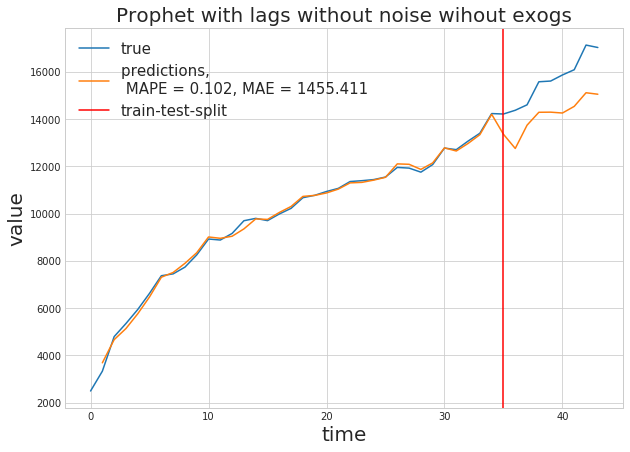

In [56]:
description = "Prophet with lags without noise wihout exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
                             y_test_with_lags, global_mode, description)

# Prophet with lags without noise with exogs

In [57]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [58]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

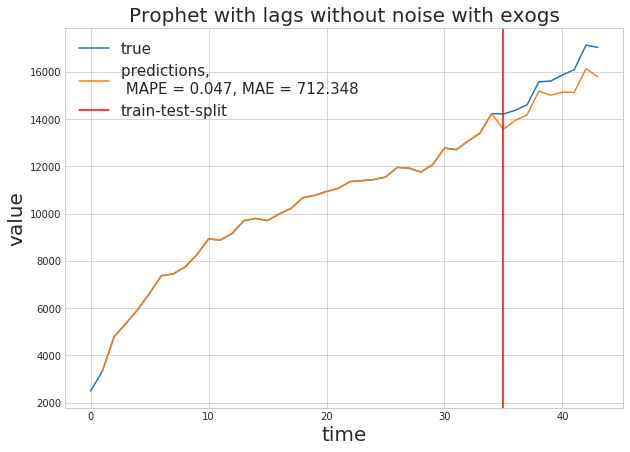

In [59]:
description = "Prophet with lags without noise with exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid Approach

In [60]:
# Global_mode
global_mode = 'pyramid'
noise_scale = None

# Generate problem

In [62]:
n_samples = 44
data_without_lags, data_with_lags, exog, Time = generate_problem_M3(n_samples, 
                                mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

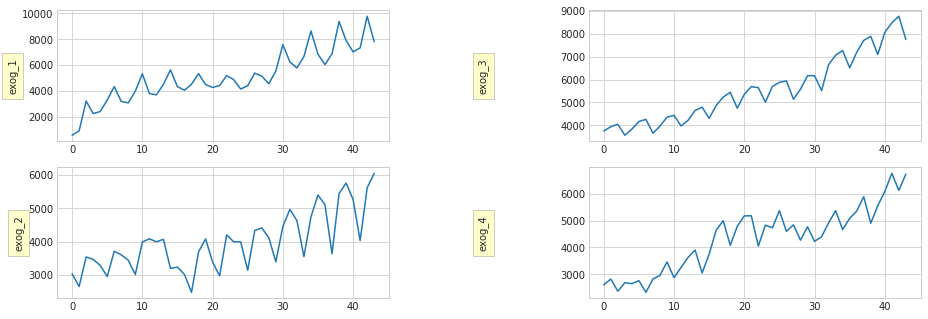

In [63]:
plotting_features(exog, global_mode)

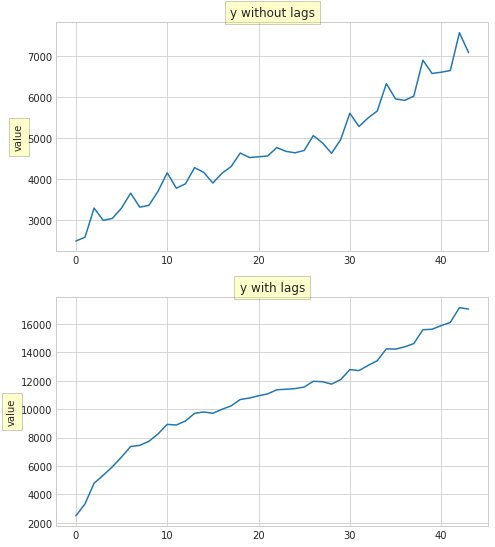

In [64]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [65]:
start_point = 0
middle_point = 35
end_point = 44

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Pyramid without lags without noise without exogs

In [66]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 4
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [67]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   35
Model:             SARIMAX(0, 1, 0)x(1, 0, 1, 4)   Log Likelihood                -229.471
Date:                           Thu, 19 Jul 2018   AIC                            466.942
Time:                                   15:39:10   BIC                            473.048
Sample:                                        0   HQIC                           469.024
                                            - 35                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1619      1.528     -0.106      0.916      -3.158       2.834
ar.S.L4        0.9990      0.009    116.094      0.000       0.982       1.016
ma.S.L4       -0.9426      0.251     -3.758      0.000      -1.434      -0.451
sigma2      3.291e+04      0.000   1.07e+08      0.000    3.29e+04    3.29e+04
===================================================================================
Ljung-Box (Q):                       75.53   Jarque-Bera (JB):                 2.06
Prob(Q):                              0.00   Prob(JB):                         0.36
Heteroskedasticity (H):               1.43   Skew:                            -0.34
Prob(H) (two-sided):                  0.56   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.27e+23. Standard errors may be unstable.
"""

In [68]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

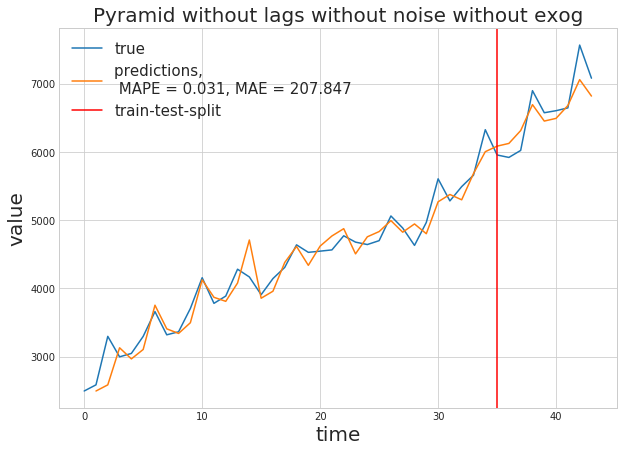

In [69]:
description = "Pyramid without lags without noise without exog"
plot_results(data_without_lags, Time, train_prediction, 
             test_prediction, y_test_without_lags, global_mode, description)

# Pyramid without lags without noise with exog

In [70]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 4
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [71]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

/home/nurlan16/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [72]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

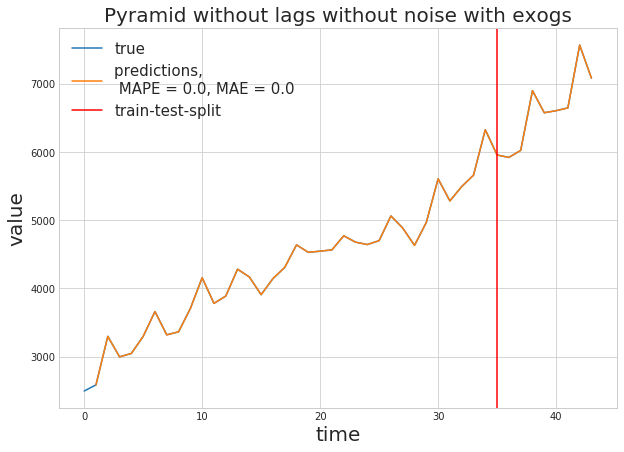

In [73]:
description = "Pyramid without lags without noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, 
             global_mode, description)

# Pyramid with lags without noise without exogs

In [74]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 4
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [75]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   35
Model:             SARIMAX(2, 2, 0)x(1, 0, 1, 4)   Log Likelihood                -225.674
Date:                           Thu, 19 Jul 2018   AIC                            463.348
Time:                                   15:40:19   BIC                            472.327
Sample:                                        0   HQIC                           466.369
                                            - 35                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3176      4.867     -0.065      0.948      -9.857       9.222
ar.L1         -0.6176      0.171     -3.622      0.000      -0.952      -0.283
ar.L2         -0.4920      0.173     -2.842      0.004      -0.831      -0.153
ar.S.L4        0.9991      0.014     72.029      0.000       0.972       1.026
ma.S.L4       -0.9536      0.354     -2.690      0.007      -1.648      -0.259
sigma2      3.894e+04      0.002   2.25e+07      0.000    3.89e+04    3.89e+04
===================================================================================
Ljung-Box (Q):                       64.36   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.00   Prob(JB):                         0.66
Heteroskedasticity (H):               1.16   Skew:                            -0.34
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.69e+22. Standard errors may be unstable.
"""

In [76]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

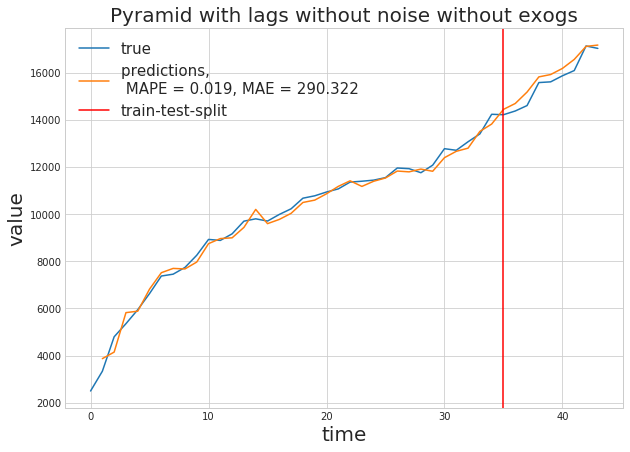

In [77]:
description = "Pyramid with lags without noise without exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid with lags without noise with exog

In [78]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 4
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [79]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

/home/nurlan16/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [80]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   35
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 4)   Log Likelihood                -228.114
Date:                           Thu, 19 Jul 2018   AIC                            476.228
Time:                                   15:41:08   BIC                            491.782
Sample:                                        0   HQIC                           481.598
                                            - 35                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     71.8165     64.093      1.121      0.262     -53.804     197.437
x1             0.2832      0.049      5.798      0.000       0.187       0.379
x2             0.1312      0.040      3.276      0.001       0.053       0.210
x3             0.2869      0.152      1.885      0.059      -0.011       0.585
x4             0.1568      0.147      1.064      0.287      -0.132       0.445
ar.L1          1.6715      0.213      7.846      0.000       1.254       2.089
ar.L2         -0.7261      0.260     -2.792      0.005      -1.236      -0.216
ar.S.L4        1.2181      0.406      2.998      0.003       0.422       2.014
ar.S.L8       -0.4195      0.365     -1.150      0.250      -1.135       0.296
sigma2      2.003e+04   8509.393      2.354      0.019    3355.748    3.67e+04
===================================================================================
Ljung-Box (Q):                       32.12   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.56   Prob(JB):                         0.80
Heteroskedasticity (H):               0.35   Skew:                            -0.23
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

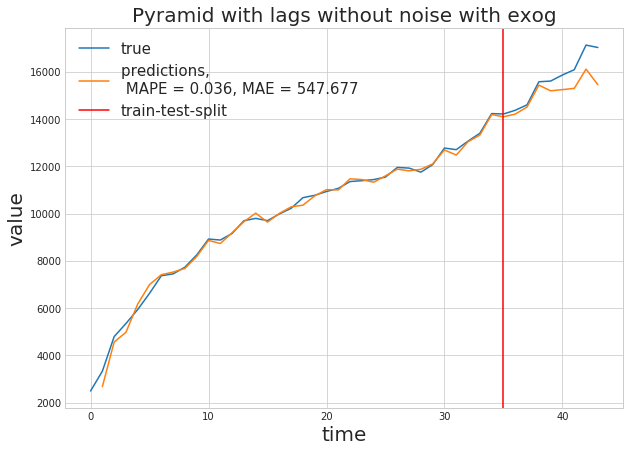

In [82]:
description = "Pyramid with lags without noise with exog"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

<b>noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise</b>

# Testing on the last dataset - linear case - with noise

# Prophet

In [104]:
# Global_mode
global_mode = 'prophet'
noise_scale = 0.1

# Generate problem

In [105]:
n_samples = 44
data_without_lags, data_with_lags, exog, Time = generate_problem_M3(n_samples, 
                        mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

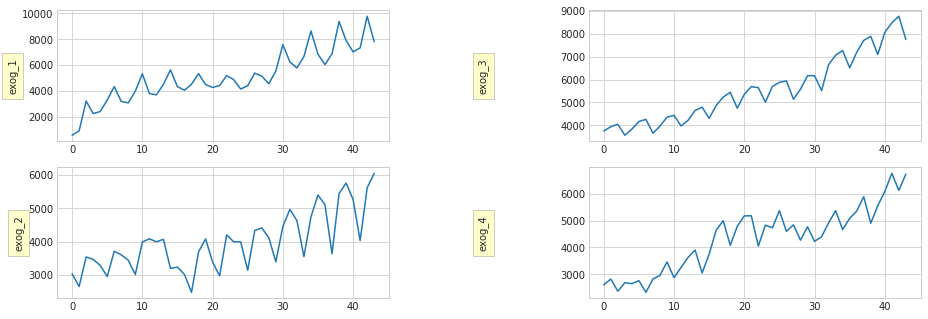

In [106]:
plotting_features(exog, global_mode)

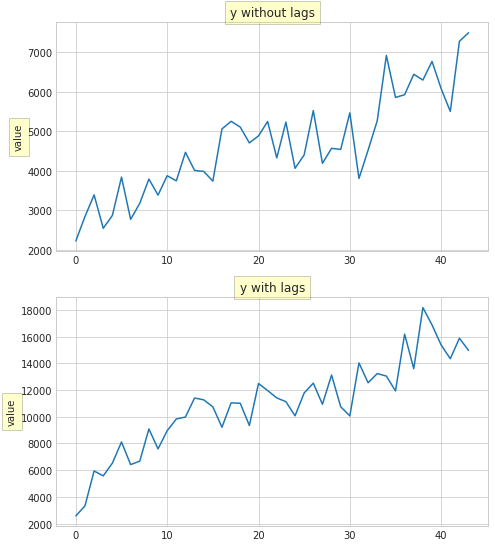

In [107]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [108]:
start_point = 0
middle_point = 35
end_point = 44

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Prophet without lags with noise without exog

In [109]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [110]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

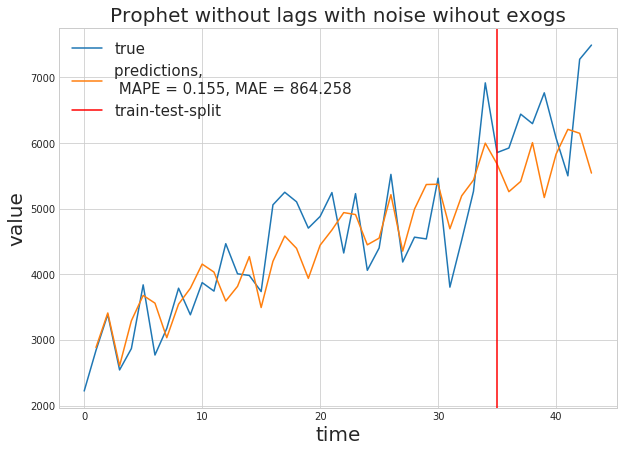

In [111]:
description = "Prophet without lags with noise wihout exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet without lags with noise with exogs 

In [112]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [113]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

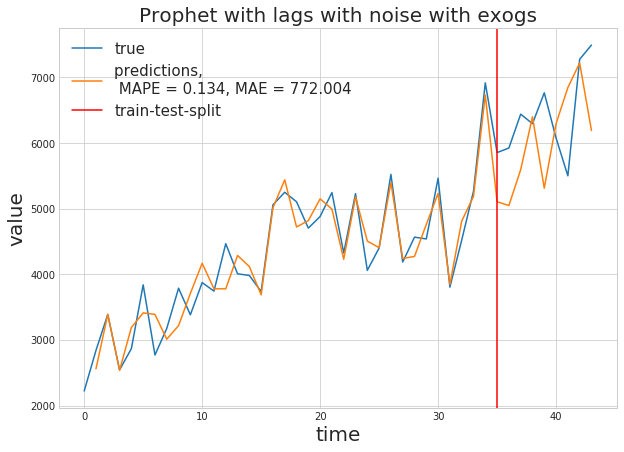

In [114]:
description = "Prophet with lags with noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet with lags with noise without exogs

In [115]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [116]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

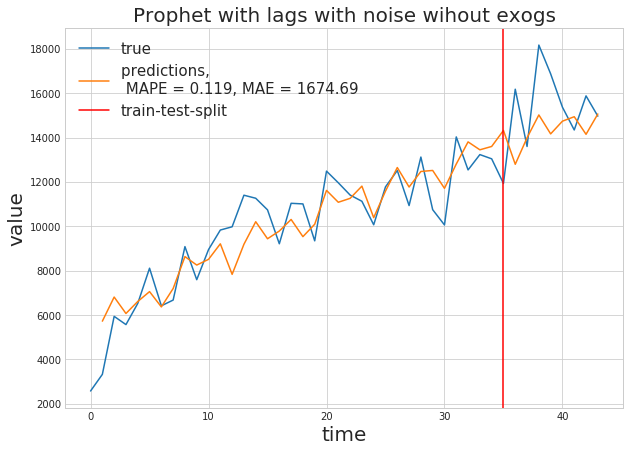

In [117]:
description = "Prophet with lags with noise wihout exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
                             y_test_with_lags, global_mode, description)

# Prophet with lags with noise with exogs

In [118]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [119]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

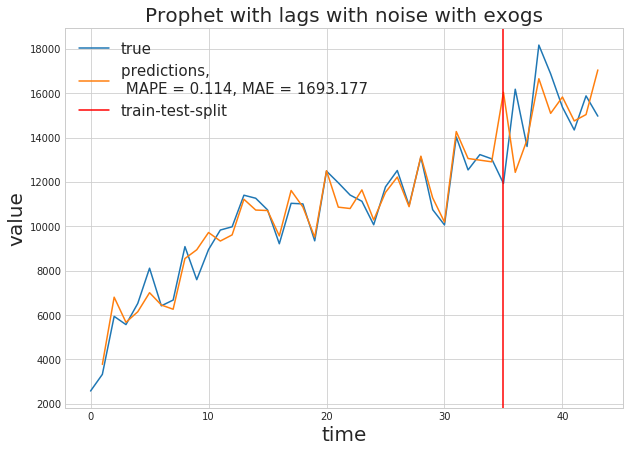

In [120]:
description = "Prophet with lags with noise with exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid Approach

In [150]:
# Global_mode
global_mode = 'pyramid'
noise_scale = 0.1

# Generate problem

In [151]:
n_samples = 44
data_without_lags, data_with_lags, exog, Time = generate_problem_M3(n_samples, 
                                mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

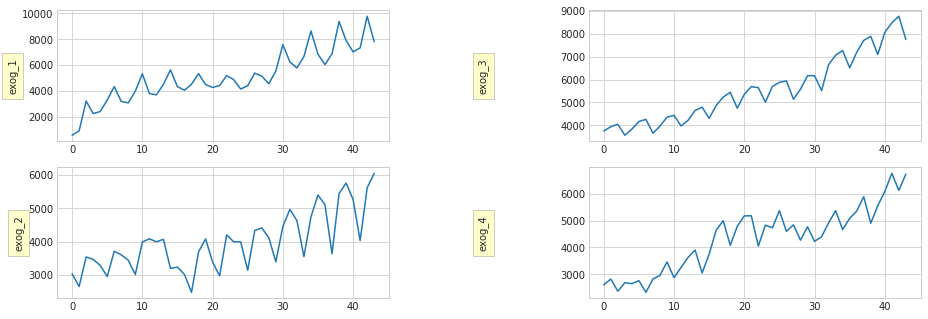

In [152]:
plotting_features(exog, global_mode)

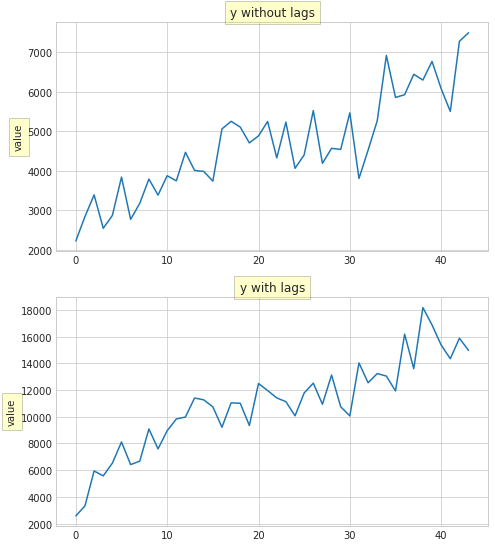

In [153]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [126]:
start_point = 0
middle_point = 35
end_point = 44

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Pyramid without lags with noise without exogs

In [128]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 4
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [129]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   35
Model:             SARIMAX(0, 1, 1)x(1, 0, 2, 4)   Log Likelihood                -263.745
Date:                           Thu, 19 Jul 2018   AIC                            539.490
Time:                                   15:44:34   BIC                            548.649
Sample:                                        0   HQIC                           542.614
                                            - 35                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    198.1267     68.698      2.884      0.004      63.482     332.772
ma.L1         -0.7997      0.153     -5.223      0.000      -1.100      -0.500
ar.S.L4       -0.9999      0.007   -137.588      0.000      -1.014      -0.986
ma.S.L4        1.9925      0.314      6.341      0.000       1.377       2.608
ma.S.L8        0.9988      0.380      2.629      0.009       0.254       1.744
sigma2       1.78e+05   8.45e-05   2.11e+09      0.000    1.78e+05    1.78e+05
===================================================================================
Ljung-Box (Q):                       31.05   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.56   Prob(JB):                         0.72
Heteroskedasticity (H):               2.50   Skew:                            -0.25
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.58e+27. Standard errors may be unstable.
"""

In [130]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

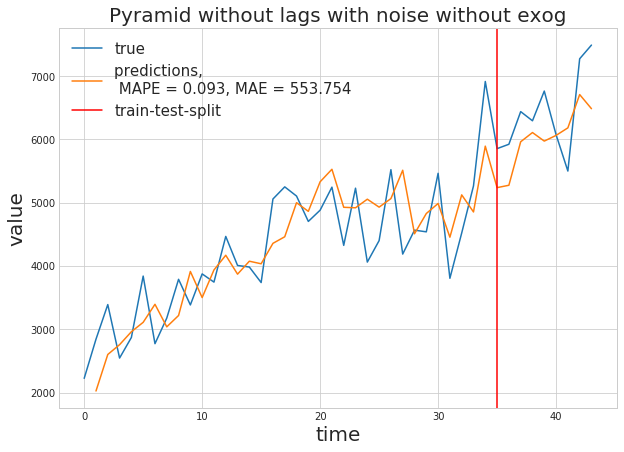

In [131]:
description = "Pyramid without lags with noise without exog"
plot_results(data_without_lags, Time, train_prediction, 
             test_prediction, y_test_without_lags, global_mode, description)

# Pyramid without lags with noise with exog

In [132]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 4
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [133]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

/home/nurlan16/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [134]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

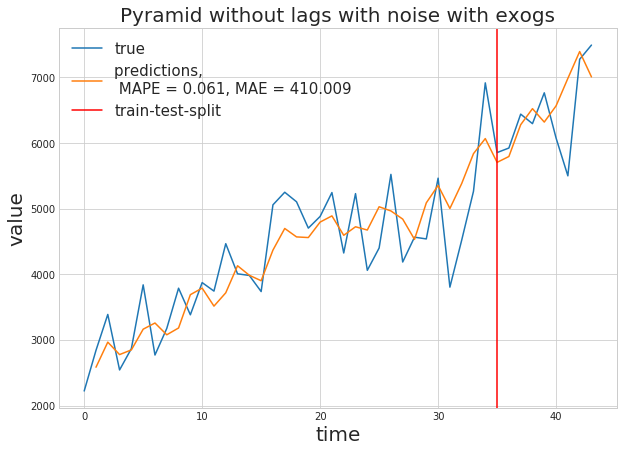

In [135]:
description = "Pyramid without lags with noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, 
             global_mode, description)

# Pyramid with lags with noise without exogs

In [137]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 4
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [138]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   35
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 4)   Log Likelihood                -291.685
Date:                           Thu, 19 Jul 2018   AIC                            591.371
Time:                                   15:46:39   BIC                            597.476
Sample:                                        0   HQIC                           593.453
                                            - 35                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    287.5129     96.326      2.985      0.003      98.718     476.308
ma.L1         -0.4440      0.179     -2.478      0.013      -0.795      -0.093
ma.S.L4       -0.2855      0.171     -1.673      0.094      -0.620       0.049
sigma2      1.588e+06   5.03e+05      3.159      0.002    6.03e+05    2.57e+06
===================================================================================
Ljung-Box (Q):                       33.92   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.42   Prob(JB):                         0.65
Heteroskedasticity (H):               1.07   Skew:                            -0.02
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

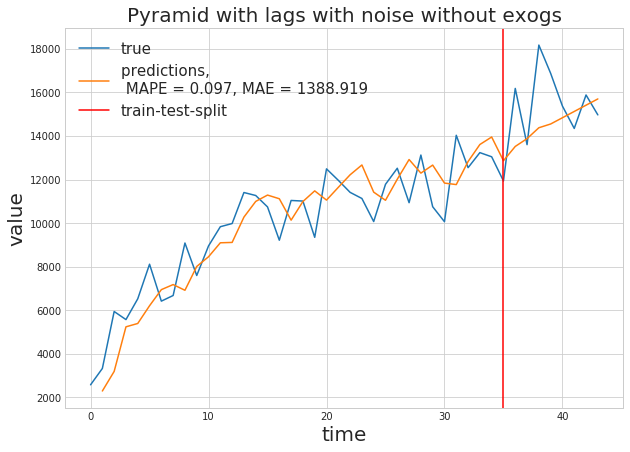

In [140]:
description = "Pyramid with lags with noise without exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid with lags with noise with exog

In [141]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 4
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [142]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

/home/nurlan16/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [143]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   35
Model:               SARIMAX(0, 0, 2)   Log Likelihood                -295.066
Date:                Thu, 19 Jul 2018   AIC                            606.133
Time:                        15:46:50   BIC                            618.576
Sample:                             0   HQIC                           610.428
                                 - 35                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    210.0461   1706.790      0.123      0.902   -3135.201    3555.293
x1             1.3068      0.272      4.796      0.000       0.773       1.841
x2             0.9745      0.787      1.239      0.215      -0.567       2.516
x3            -1.7363      0.506     -3.430      0.001      -2.728      -0.744
x4             2.2658      0.308      7.345      0.000       1.661       2.870
ma.L1         -0.5371      0.423     -1.271      0.204      -1.365       0.291
ma.L2         -0.4213      0.340     -1.238      0.216      -1.088       0.245
sigma2      1.519e+06      0.018   8.29e+07      0.000    1.52e+06    1.52e+06
===================================================================================
Ljung-Box (Q):                       19.40   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.98   Prob(JB):                         0.92
Heteroskedasticity (H):               2.14   Skew:                             0.13
Prob(H) (two-sided):                  0.20   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.82e+25. Standard errors may be unstable.
"""

In [144]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

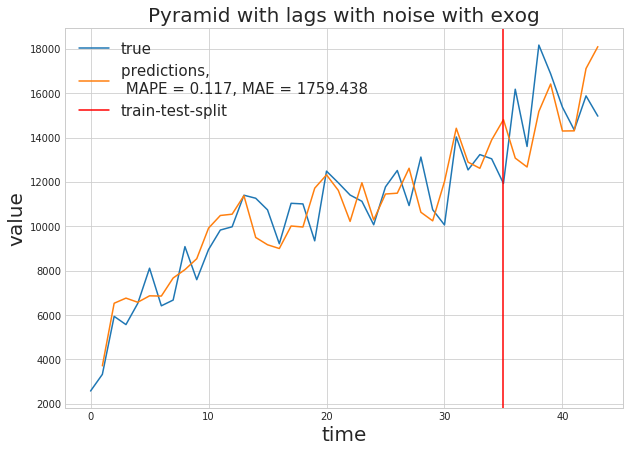

In [145]:
description = "Pyramid with lags with noise with exog"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)